In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import pandas as pd
import numpy as np
import os

from utils.rpos import *
from ggplot import *

In [3]:
# Sample titles with corresponding barcodes
samples = {
    's9': ['ATCACG', 'ACAGTG'],
    's9+bcm': ['CGATGT', 'GCCAAT'],
    's17': ['TTAGGC', 'GATCAG'],
    's17+bcm': ['TGACCA', 'TAGCTT'],
    's19': ['CAGATC','GGCTAC'],
    's19+bcm': ['ACTTGA', 'CTTGTA']
}

# Barcodes
barcodes = ['ATCACG', 'ACAGTG', 'CGATGT', 'GCCAAT', 'TTAGGC', 'GATCAG', 'TGACCA', 'TAGCTT', 'CAGATC','GGCTAC', 'ACTTGA', 'CTTGTA']

def get_counts_df(barcodes, res_dir='../results'):
    '''
    Aggregates htseq-count results into raw counts dataframe.
    Iterates over files whose name ends with '.counts' in `res_dir` and contains barcodes
    specified in `barcodes`.
    
    Builds a dataframe containing gene names and counts for the gene for every barcode.
    '''
    df = pd.DataFrame()
    d, _, filenames = os.walk(res_dir).next()
    infiles = [f for f in filenames if f.endswith('.counts')]
    for barcode in barcodes:
        cntfile = os.path.join(d, [f for f in infiles if barcode in f][0])
        df_ = pd.read_csv(cntfile, sep='\t', header=None, names=['gene','counts'])
        if df.empty:
            df['gene'] = df_['gene']
        df[barcode] = df_['counts']
    return df[~df['gene'].str.startswith('__')]

def get_utr_counts_df(df, barcodes, res_dir='../results'):
    '''
    Calculates 5'UTR coverage
    Iterates over files whose name ends with '_sorted.bam' in `res_dir` and contains barcodes
    specified in `barcodes`.
    
    Adds `utr_<barcode>` column to df DataFrame
    '''
    d, _, filenames = os.walk(res_dir).next()
    infiles = [f for f in filenames if f.endswith('_sorted.bam')]
    for barcode in barcodes:
        bamfile = os.path.join(d, [f for f in infiles if barcode in f][0])
        #df['utr_{0}'.format(barcode)] = get_coverage(df, bamfile, 'gi|556503834|ref|NC_000913.3|',
        #                                             key5='coord_5', key3='coord_3')
        df['utr_{0}'.format(barcode)] = get_counts(df, bamfile, 'gi|556503834|ref|NC_000913.3|',
                                                     key5='coord_5', key3='coord_3')
        

In [4]:
df_utr5 = get_utr5_df('../ref/UTR_5_3_sequence.txt')
df_utr5['UTR_length'] = abs(df_utr5['coord_5'] - df_utr5['coord_3'])
df_utr5 = df_utr5[df_utr5['UTR_length'] > 80]
max_length = df_utr5['UTR_length'].max() + 1
num_utrs = df_utr5.shape[0]

In [5]:
def get_utr_array(df, barcodes, reference, res_dir='../results'):
    
    def get_coverage_vector(rec):
        utr = np.zeros(shape=(max_length,), dtype=np.int16)
        start,end = rec['coord_5'], rec['coord_3']
        if start > end:
            start,end = end,start

        pileup = bamfile.pileup(reference, start, end)
        for i,col in enumerate(pileup):
            # I don't know why
            try:
                utr[i] = col.n
            except IndexError:
                pass
            #utr_lengths.append(i)
        return utr

    result = []
    d, _, filenames = os.walk(res_dir).next()
    infiles = [f for f in filenames if f.endswith('_sorted.bam')]
    for barcode in barcodes:
        filename = os.path.join(d, [f for f in infiles if barcode in f][0])
        data = np.ndarray(shape=(num_utrs, max_length), dtype=np.int16)
        bamfile = pysam.AlignmentFile(filename, 'rb')
        #data = df.apply(get_coverage_vector, axis=1)
        #result.append(data1)
        for (i, row) in enumerate(df.iterrows()):
            data[i] = get_coverage_vector(row[1])
        result.append(data)
    return result


In [6]:
data = get_utr_array(df_utr5, ['ATCACG'], 'gi|556503834|ref|NC_000913.3|')
data1 = get_utr_array(df_utr5, ['ACAGTG'], 'gi|556503834|ref|NC_000913.3|')
data_bcm = get_utr_array(df_utr5, ['GCCAAT'], 'gi|556503834|ref|NC_000913.3|')
data_bcm1 = get_utr_array(df_utr5, ['CGATGT'], 'gi|556503834|ref|NC_000913.3|')

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm
import math

In [12]:
def plot_utr_heatmap(data, cmap=cm.OrRd, ylim=[1750, 1500], orientation='vertical'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    utr = data[0].copy()
    utr.sort(axis=0)
    max_val = np.max(utr)
    midpoint = math.ceil(max_val / 2)
    fig, ax = plt.subplots(figsize=(18,18))
    im = ax.imshow(utr,cmap=cmap)
    ax.set_title("Read depth at 5'UTR", fontsize=20)
    ax.set_ylim(ylim)
    ax.set_xlabel('Position from TSS', fontsize=20)
    ax.get_yaxis().set_ticks([])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, ticks=[0,midpoint,max_val], orientation=orientation)
    cbar.ax.invert_yaxis()
    cbar.ax.set_xticklabels(['0', '{0}'.format(int(midpoint)), '{0}'.format(int(max_val))], fontsize=20)
    plt.show()

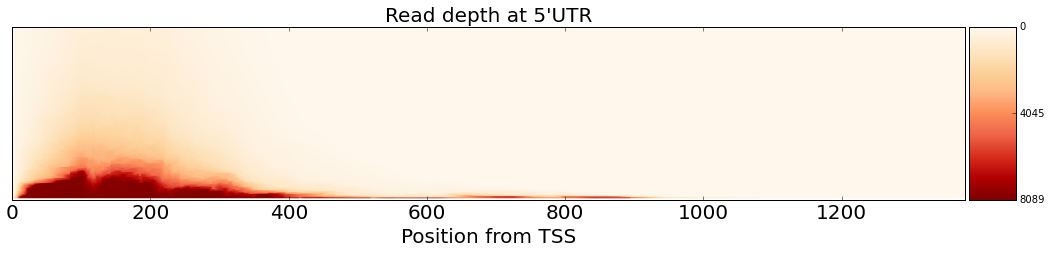

In [13]:
plot_utr_heatmap(data)

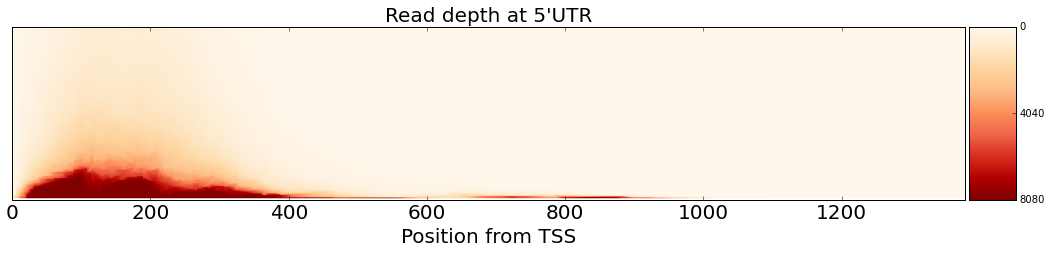

In [14]:
plot_utr_heatmap(data1)

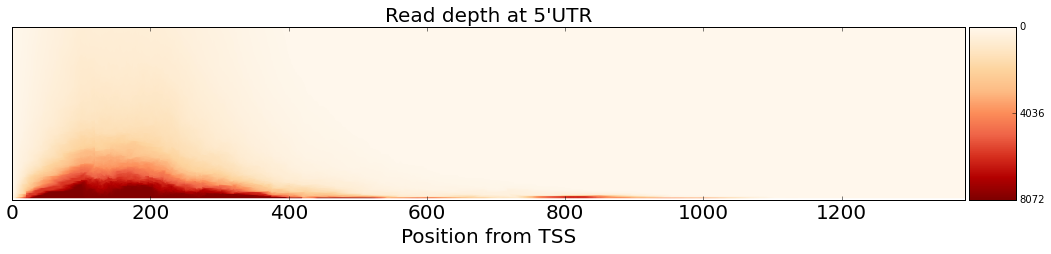

In [15]:
plot_utr_heatmap(data_bcm)

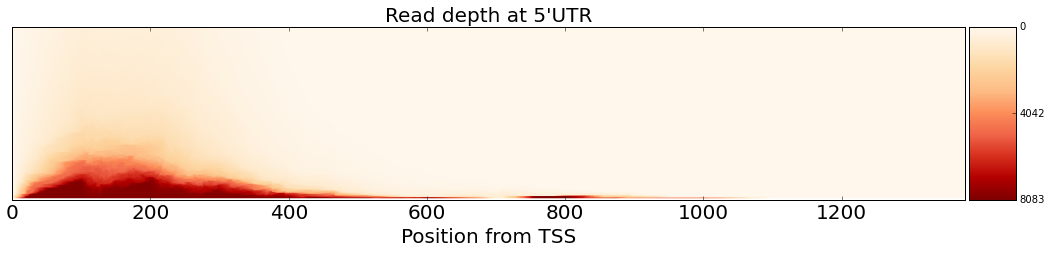

In [16]:
plot_utr_heatmap(data_bcm1)

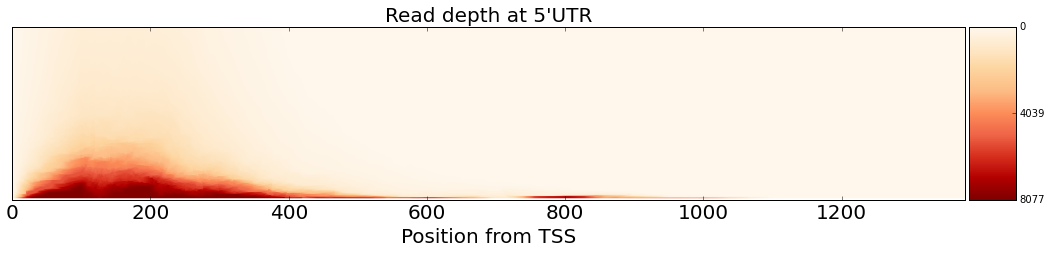

In [17]:
plot_utr_heatmap([(data_bcm[0] + data_bcm1[0]) / 2.])

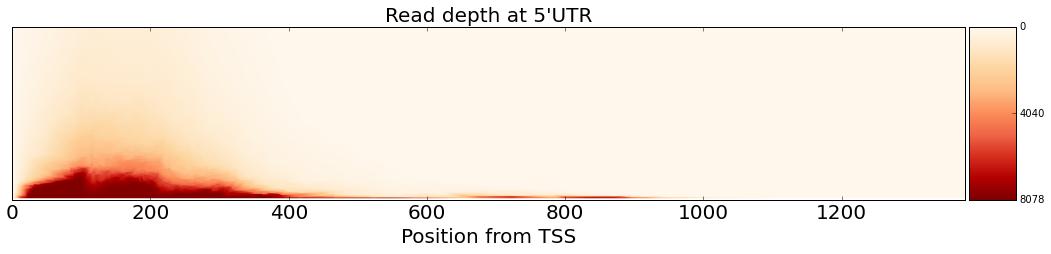

In [18]:
plot_utr_heatmap([(data[0] + data1[0]) / 2.])

In [164]:
win = 20
quart = 0.5

df = pd.DataFrame(np.sort((data[0] + data1[0]) / 2., axis=0))
mask = (df > np.max(df.max()) * quart)
col1 = pd.rolling_mean(df[mask].cumsum()[-1:].transpose(), win)

df = pd.DataFrame(np.sort((data_bcm[0] + data_bcm1[0]) / 2., axis=0))
mask = (df > np.max(df.max()) * quart)
col2 = pd.rolling_mean(df[mask].cumsum()[-1:].transpose(), win)

In [165]:
df1 = pd.DataFrame()
df1['sum'] = col1[1747]
df1['BCM'] = '-'
df1['pos'] = df1.index

df2 = pd.DataFrame()
df2['sum'] = col2[1747]
df2['BCM'] = '+'
df2['pos'] = df2.index

df = pd.concat([df1,df2])
df = df.dropna().reset_index(drop=True)
df['sum'] = df['sum'] / 1e5

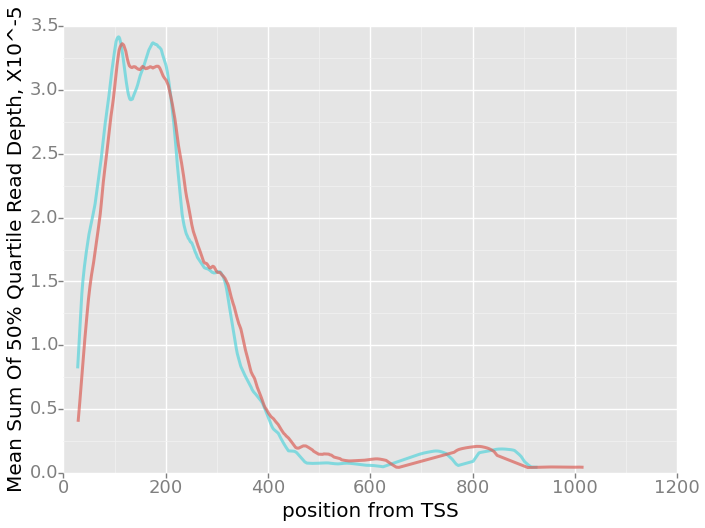

<ggplot: (8792809470821)>


In [166]:
p = ggplot(df, aes(x='pos', y='sum', color='BCM')) \
    + geom_line(size=3, alpha=0.7) \
    + scale_x_continuous(name="position from TSS") \
    + scale_y_continuous(name="Mean sum of 50% quartile read depth, x10^-5") \
    + theme(axis_title=element_text(size=20),
            axis_text=element_text(size=18)) 
    
print p

In [186]:
import seaborn as sns
sns.set_palette("deep", desat=0.6)
sns.set_context(rc={"figure.figsize": (8,6)})

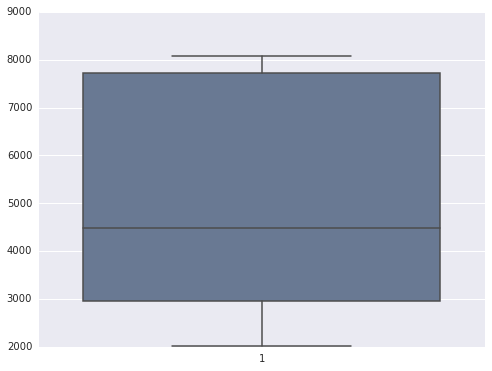

In [193]:
d = data[0].flatten()
dmax = np.max(d)
sns.boxplot(d[d > 0.25 * dmax])